# Indicateur données officielles par région / département

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Pour la sonnerie à la fin de l'exécution d'un programme
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz

## Avec données officielles mensuelles

In [3]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])
df_France_Official_Data2.head(3)

,date,department,value_in_thousands
0,2011-01-01,Ain,47.32
1,2011-01-01,Aisne,21.78
2,2011-01-01,Allier,23.62


In [4]:
#Base avec les régions :
base_regions_dep = pd.read_csv('departements-region.csv')
base_regions_dep.rename(columns={'dep_name': 'department'}, inplace=True)
base_regions_dep.head(3)

,num_dep,department,region_name
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes


In [5]:
#On merge pour rajouter la colonne région
df_France_Official_Data3 = df_France_Official_Data2.merge(base_regions_dep, on='department', how='left')
df_France_Official_Data3.head(3)

,date,department,value_in_thousands,num_dep,region_name
0,2011-01-01,Ain,47.32,01,Auvergne-Rhône-Alpes
1,2011-01-01,Aisne,21.78,02,Hauts-de-France
2,2011-01-01,Allier,23.62,03,Auvergne-Rhône-Alpes


In [6]:
#Fonction qui réduit la base des données officielles à 1 seul département :

def reduc_base_departement(departement):
       
    #Données département
    df_Official_Data_dep = df_France_Official_Data3[df_France_Official_Data3['department']==departement]
    
    #On regroupe par mois
    df_Official_Data_dep2 = df_Official_Data_dep.groupby('date').sum() 

    return(df_Official_Data_dep2)

In [7]:
#Fonction qui réduit la base des données officielles à 1 seule région :

def reduc_base_region(region):
        
    #Données région
    df_Official_Data_region = df_France_Official_Data3[df_France_Official_Data3['region_name']==region]
    
    #On regroupe par mois
    df_Official_Data_region2 = df_Official_Data_region.groupby('date').sum() 

    return(df_Official_Data_region2)

In [8]:
#reduc_base_departement("Paris")

In [9]:
#reduc_base_region("Pays de la Loire")

In [10]:
def choix_modele_sarima(pmax, dmax, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    d = range(0, dmax)
    pdq = list(itertools.product(p, d, q))

    p2 = d2 = q2 = range(0, 2)
    seasonal_pdq = list(itertools.product(p2,d2,q2))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(parametres_bic[best_bic])
    
    return(parametres_bic[best_bic])

In [11]:
def modele_donnees_off(dep_region, pmax, dmax, qmax):
    
    #on importe les données officielles pour le département ou la région demandé(e) :
    if (dep_region in df_France_Official_Data3["region_name"].unique()):
        df_Official_Data = reduc_base_region(dep_region)
        print("region")
    elif (dep_region in df_France_Official_Data3["department"].unique()):
        df_Official_Data = reduc_base_departement(dep_region)
        print("departement")
    else:
        print(dep_region, " n'est ni un département, ni une région française.")
        return None
    
    #pour avoir une base où la colonne des dates n'est pas en index
    df_Official_Data_index = df_Official_Data.reset_index()
   
    #on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponibles
    df_donnees_dispo = df_Official_Data_index[df_Official_Data_index['date']<"2018-01-01"]
    df_donnees_dispo.set_index('date', inplace=True)

    
    #choix du modèle qui minimise le BIC
    parametres_modele = choix_modele_sarima(pmax, dmax, qmax, df_donnees_dispo)
    
    #on fit le modèle sur ces données
    modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                            order=parametres_modele[0],
                                            seasonal_order=parametres_modele[1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    resultats_prev = modele_prev.fit()
    
    
    #on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

    df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
    df_forecast['date'] = df_Official_Data_index['date'][(df_Official_Data_index['date']<'2021-10-01') &
                                                               (df_Official_Data_index['date']>="2018-01-01")]
    df_forecast.set_index('date', drop=False, inplace=True)
    
    
    #on remplit la base
    
    resultats_prev_new = resultats_prev

    for date in df_forecast['date']:

        #La valeur prédite :
        if ( float(resultats_prev_new.forecast(date)) >= 0):
            df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
        else:
            df_forecast.loc[date, 'valeur_predite'] = 0
        #je mets dans le dataframe la prédiction pour la date

        # La nouvelle observation qu'on a à disposition
        new_data = df_Official_Data.loc[date, "value_in_thousands"]

        #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
        new_data2 = df_Official_Data_index[df_Official_Data_index['date']==date]
        new_data2.set_index('date', inplace=True)

        #On met la nouvelle observation dans le dataframe
        df_forecast.loc[date, 'donnee_officielle'] = new_data

        #Nouveau modèle fitté avec une donnée de plus :
        resultats_prev_new = resultats_prev_new.append(new_data2)

        
    df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
    
    return(df_forecast)

In [12]:
#modele_donnees_off("Pays de la Loire", 4, 2, 4)

## Avec les données officielles transformées en journalières

In [13]:
#Importe données officielles journalières
df_France_Official_Data_jour = pd.read_csv("donnees_off_interpolees.csv", index_col=0)
df_France_Official_Data_jour['date'] = pd.to_datetime(df_France_Official_Data_jour['date'])
df_France_Official_Data_jour

,value_in_thousands,department,date
0,47.32,Ain,2011-01-01
1,21.78,Aisne,2011-01-01
2,23.62,Allier,2011-01-01
3,170.80,Alpes-Maritimes,2011-01-01
4,15.27,Alpes-de-Haute-Provence,2011-01-01
...,...,...,...
376987,82.39,Vendée,2021-10-01
376988,96.87,Vienne,2021-10-01
376989,39.99,Vosges,2021-10-01
376990,41.35,Yonne,2021-10-01


In [14]:
#On merge pour rajouter la colonne région
df_France_Official_Data_jour2 = df_France_Official_Data_jour.merge(base_regions_dep, on='department', how='left')
df_France_Official_Data_jour2.head(3)

,value_in_thousands,department,date,num_dep,region_name
0,47.32,Ain,2011-01-01,01,Auvergne-Rhône-Alpes
1,21.78,Aisne,2011-01-01,02,Hauts-de-France
2,23.62,Allier,2011-01-01,03,Auvergne-Rhône-Alpes


In [15]:
#Fonction qui réduit la base des données officielles à 1 seul département :

def reduc_base_departement_jour(departement):
       
    #Données département
    df_Official_Data_jour_dep = df_France_Official_Data_jour2[df_France_Official_Data_jour2['department']==departement]
    
    #On regroupe par mois
    df_Official_Data_jour_dep2 = df_Official_Data_jour_dep.groupby('date').sum() 

    return(df_Official_Data_jour_dep2)

In [16]:
#Fonction qui réduit la base des données officielles à 1 seule région :

def reduc_base_region_jour(region):
        
    #Données région
    df_Official_Data_jour_region = df_France_Official_Data_jour2[df_France_Official_Data_jour2['region_name']==region]
    
    #On regroupe par mois
    df_Official_Data_jour_region2 = df_Official_Data_jour_region.groupby('date').sum() 

    return(df_Official_Data_jour_region2)

In [17]:
#reduc_base_departement_jour("Paris")

In [18]:
#reduc_base_region_jour("Pays de la Loire")

In [19]:
def modele_donnees_off_jour(dep_region, pmax, dmax, qmax):
    
    #on importe les données officielles pour le département ou la région demandé(e) :
    if (dep_region in df_France_Official_Data_jour2["region_name"].unique()):
        df_Official_Data = reduc_base_region_jour(dep_region)
        print("region")
    elif (dep_region in df_France_Official_Data_jour2["department"].unique()):
        df_Official_Data = reduc_base_departement_jour(dep_region)
        print("departement")
    else:
        print(dep_region, " n'est ni un département, ni une région française.")
        return None
    
    #pour avoir une base où la colonne des dates n'est pas en index
    df_Official_Data_index = df_Official_Data.reset_index()
   
    #on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponibles
    df_donnees_dispo = df_Official_Data_index[df_Official_Data_index['date']<"2018-01-01"]
    df_donnees_dispo.set_index('date', inplace=True)

    
    #choix du modèle qui minimise le BIC
    parametres_modele = choix_modele_sarima(pmax, dmax, qmax, df_donnees_dispo)
    
    #on fit le modèle sur ces données
    modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                            order=parametres_modele[0],
                                            seasonal_order=parametres_modele[1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    resultats_prev = modele_prev.fit()
    
    
    #on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

    df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
    df_forecast['date'] = df_Official_Data_index['date'][(df_Official_Data_index['date']<'2021-10-01') &
                                                               (df_Official_Data_index['date']>="2018-01-01")]
    df_forecast.set_index('date', drop=False, inplace=True)
    
    
    #on remplit la base
    
    resultats_prev_new = resultats_prev

    for date in df_forecast['date']:

        #La valeur prédite :
        if ( float(resultats_prev_new.forecast(date)) >= 0):
            df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
        else:
            df_forecast.loc[date, 'valeur_predite'] = 0
        #je mets dans le dataframe la prédiction pour la date

        # La nouvelle observation qu'on a à disposition
        new_data = df_Official_Data.loc[date, "value_in_thousands"]

        #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
        new_data2 = df_Official_Data_index[df_Official_Data_index['date']==date]
        new_data2.set_index('date', inplace=True)

        #On met la nouvelle observation dans le dataframe
        df_forecast.loc[date, 'donnee_officielle'] = new_data

        #Nouveau modèle fitté avec une donnée de plus :
        resultats_prev_new = resultats_prev_new.append(new_data2)

        
    df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
    
    return(df_forecast)

region
[(2, 1, 1), (0, 0, 0, 12)]


,date,valeur_predite,donnee_officielle
date,,,
2018-01-01,2018-01-01,257.061667,257.02
2018-01-02,2018-01-02,256.435761,257.474516
2018-01-03,2018-01-03,257.954033,257.929032
2018-01-04,2018-01-04,258.408365,258.383548
2018-01-05,2018-01-05,258.862698,258.838065
...,...,...,...
2021-09-26,2021-09-26,401.481022,401.488333
2021-09-27,2021-09-27,399.983929,399.990667
2021-09-28,2021-09-28,398.486836,398.493


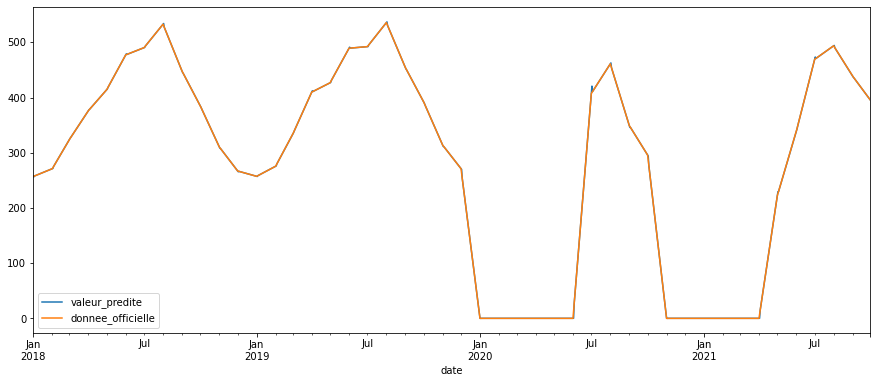

In [21]:
modele_donnees_off_jour("Pays de la Loire", 4, 2, 4)

winsound.Beep(freq, duration)